# Mock data fitting results

Analyze mock data fitting results

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coords
# plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import arviz as az
import seaborn as sns
from corner import corner

# project
import pystan
import gapipes as gp
import kinesis as kn
print(f"pystan v{pystan.__version__}")
np.random.seed(18324)

pystan v2.19.1.1


In [67]:
fit = kn.load_stanfit('../scripts/mock_null.pickle')
azfit = az.from_pystan(fit)

In [70]:
from IPython.display import display, HTML
# remove latent params to individual stars
var_names = list(azfit.posterior.data_vars.keys())
var_names.remove('probmem')
for x in list(filter(lambda x:'_model' in x, var_names)): var_names.remove(x)
with pd.option_context("display.max_rows", 100):
    display(HTML(az.summary(azfit, var_names).to_html()))

/home/soh/.conda/envs/nitro/lib/python3.7/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


## Corner plot - all parameters

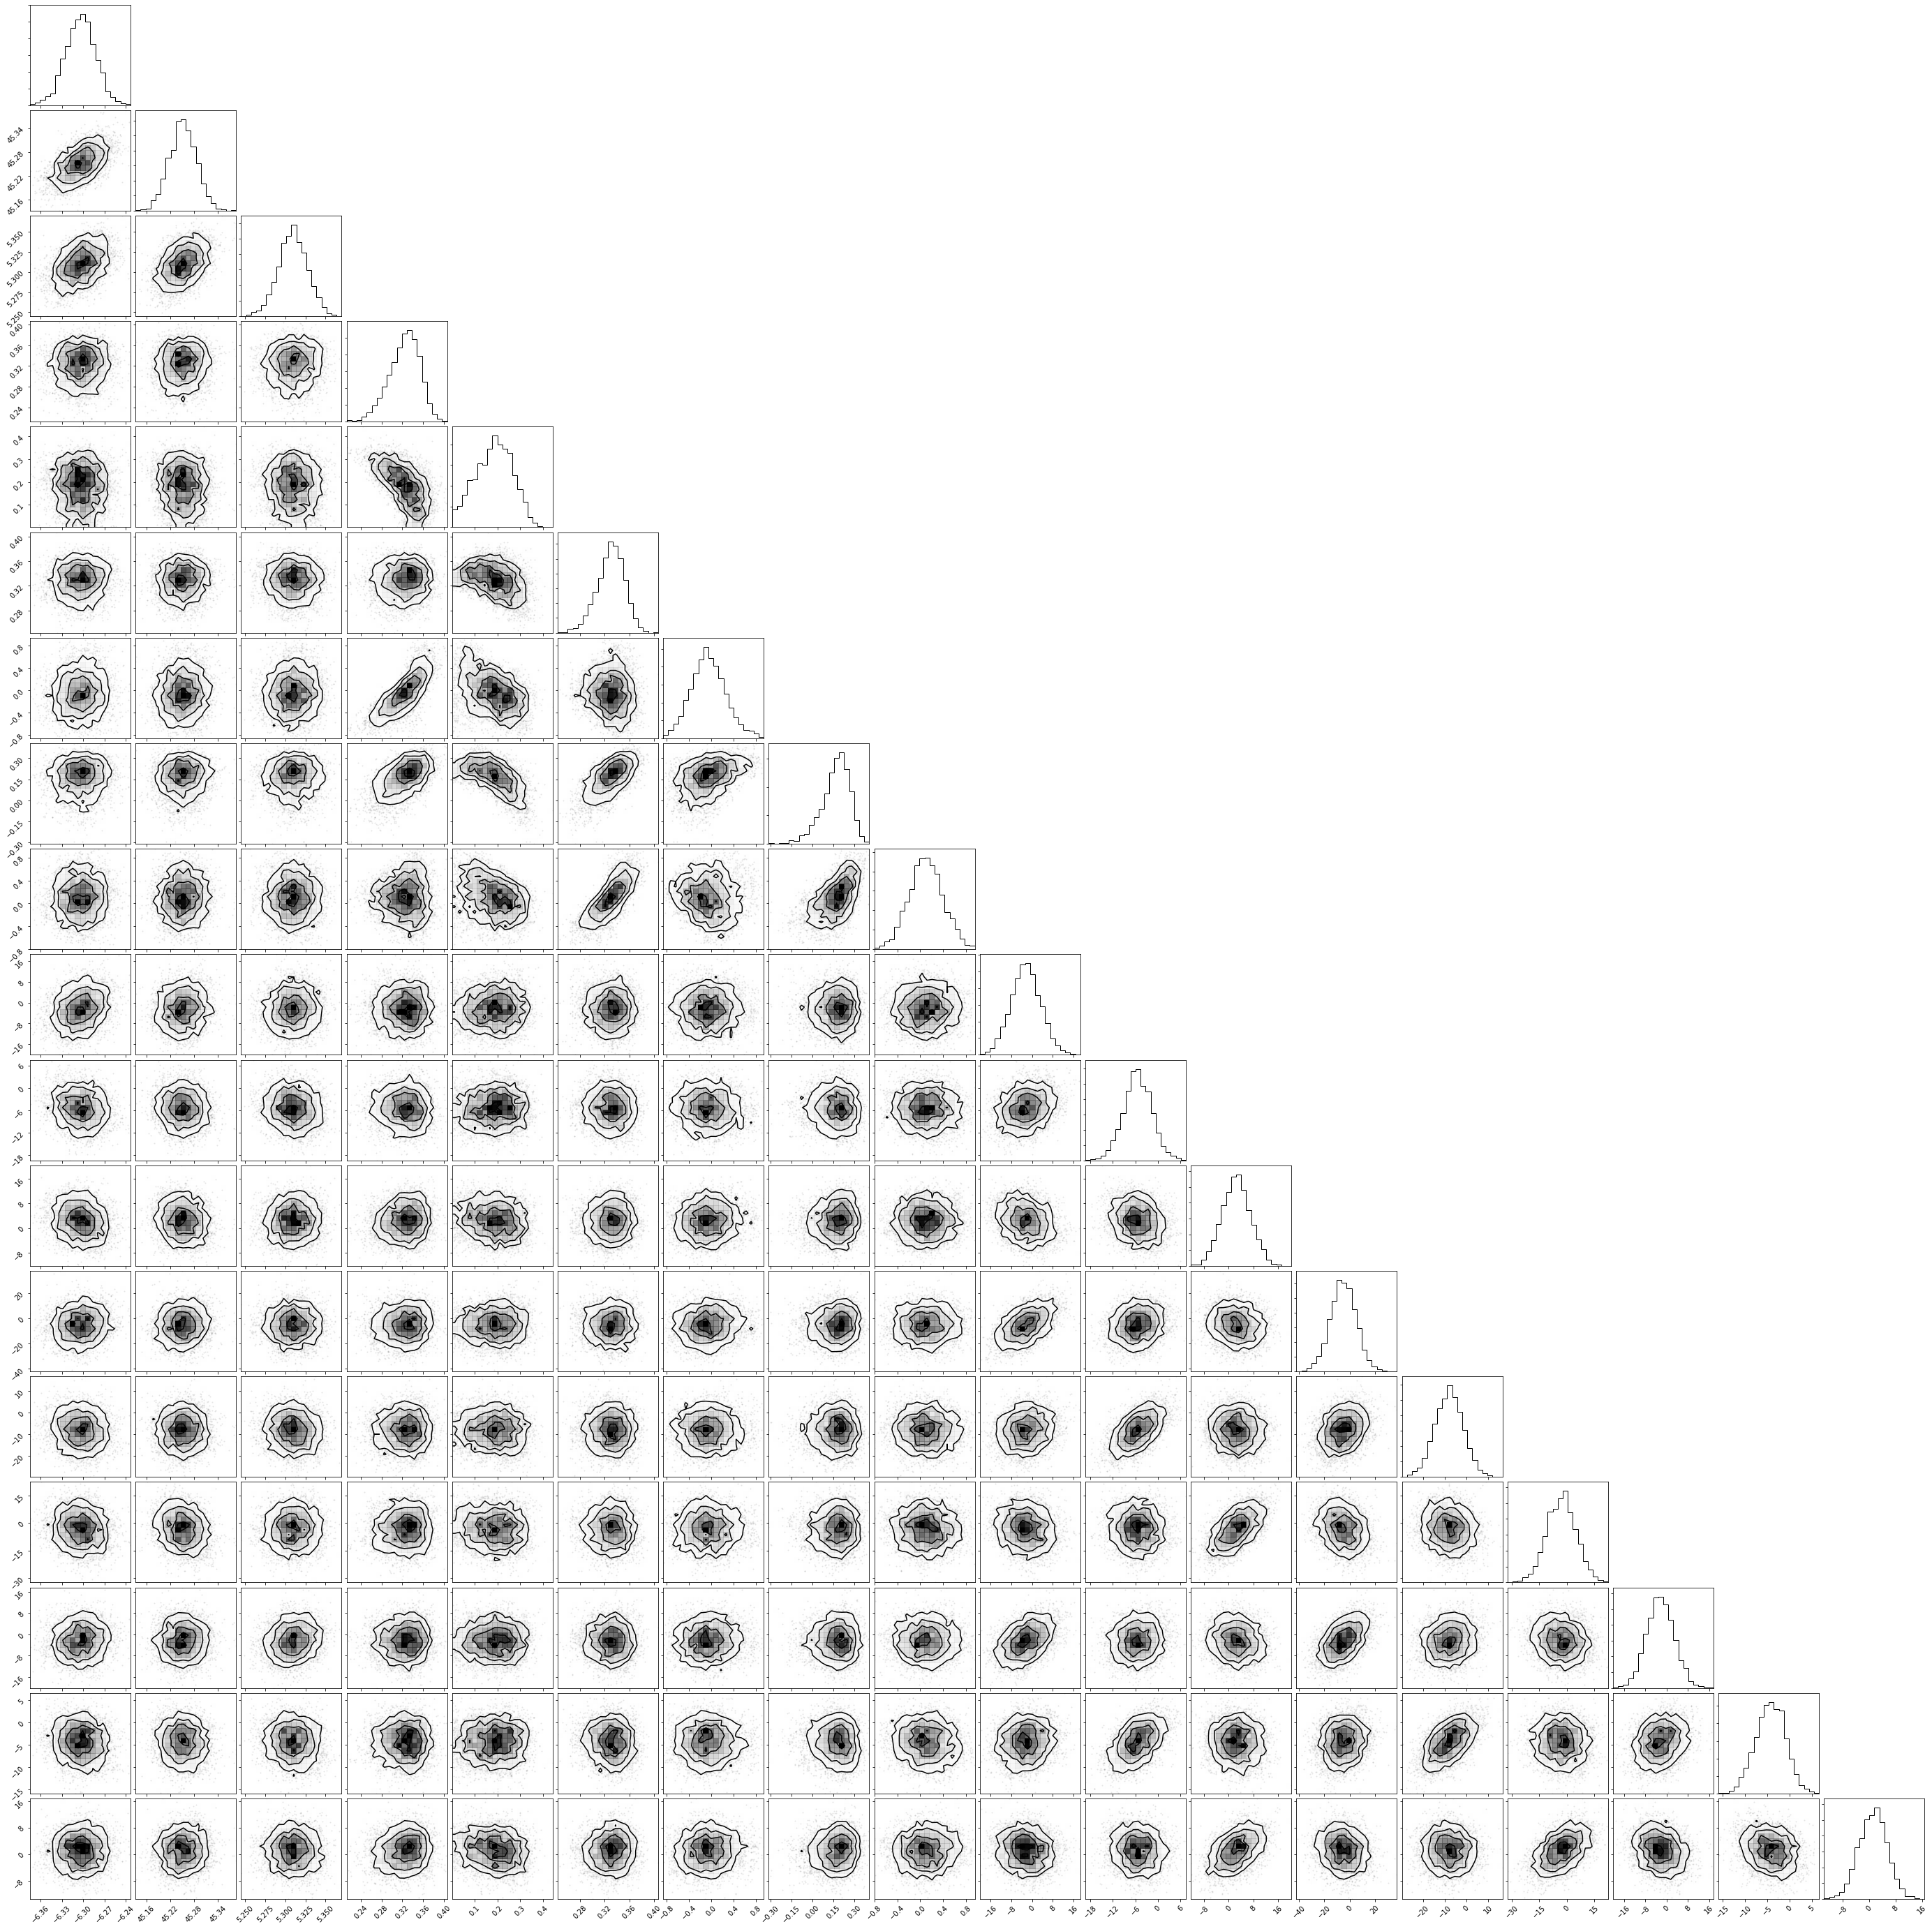

In [44]:
# labels = ['sigvx','sigvy','sigvz','Omega_xy','Omega_xz','Omega_yz']
irow,icol = np.triu_indices(3,k=1)
Omega = fit['Omega'][:,irow,icol]

X = np.concatenate((fit['v0'], fit['sigv'], Omega, fit['T_param'].reshape((4000,-1))), axis=1)
# truths = [0.3,0.3,0.3,0,0,0]
corner(X);

## Corner plot - v0 and dispersion scale

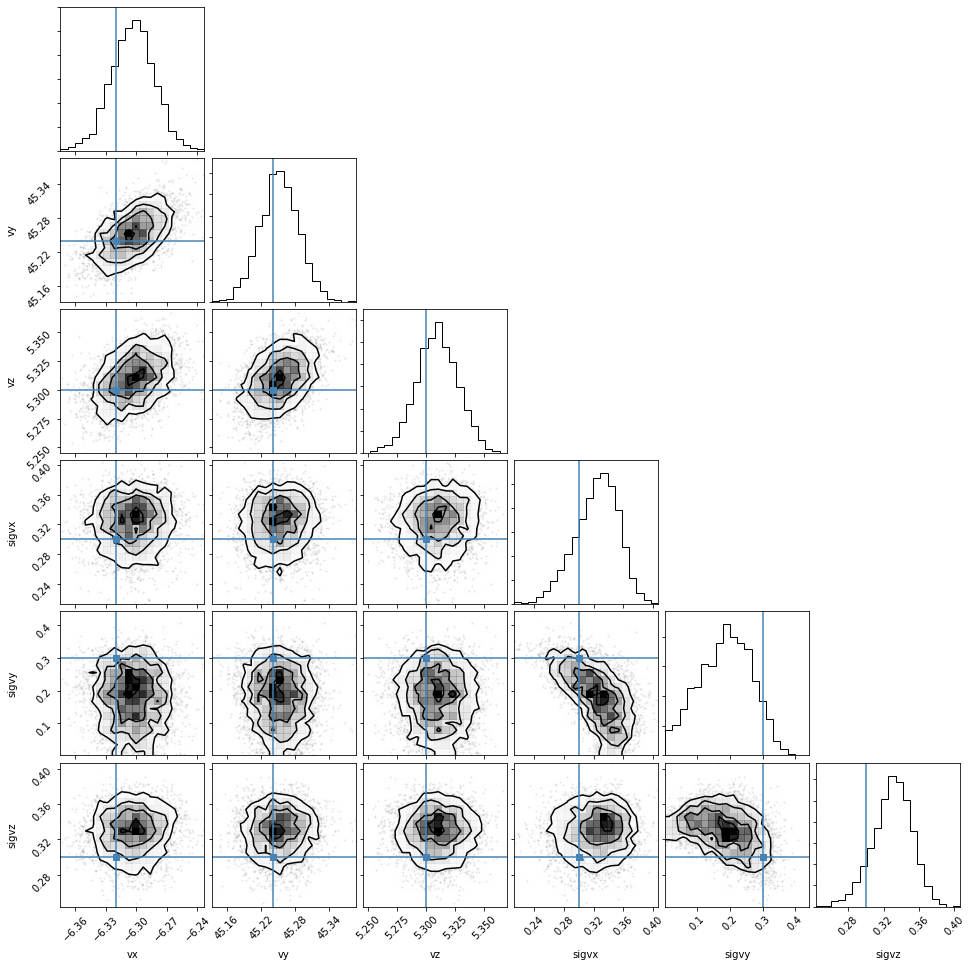

In [43]:
labels = ['vx','vy','vz','sigvx','sigvy','sigvz']
X = np.concatenate((fit['v0'], fit['sigv']), axis=1)
truths = [-6.32, 45.24, 5.30,0.3,0.3,0.3]
corner(X, labels=labels,truths=truths);

## Corner plot - dispersion scale and correlation

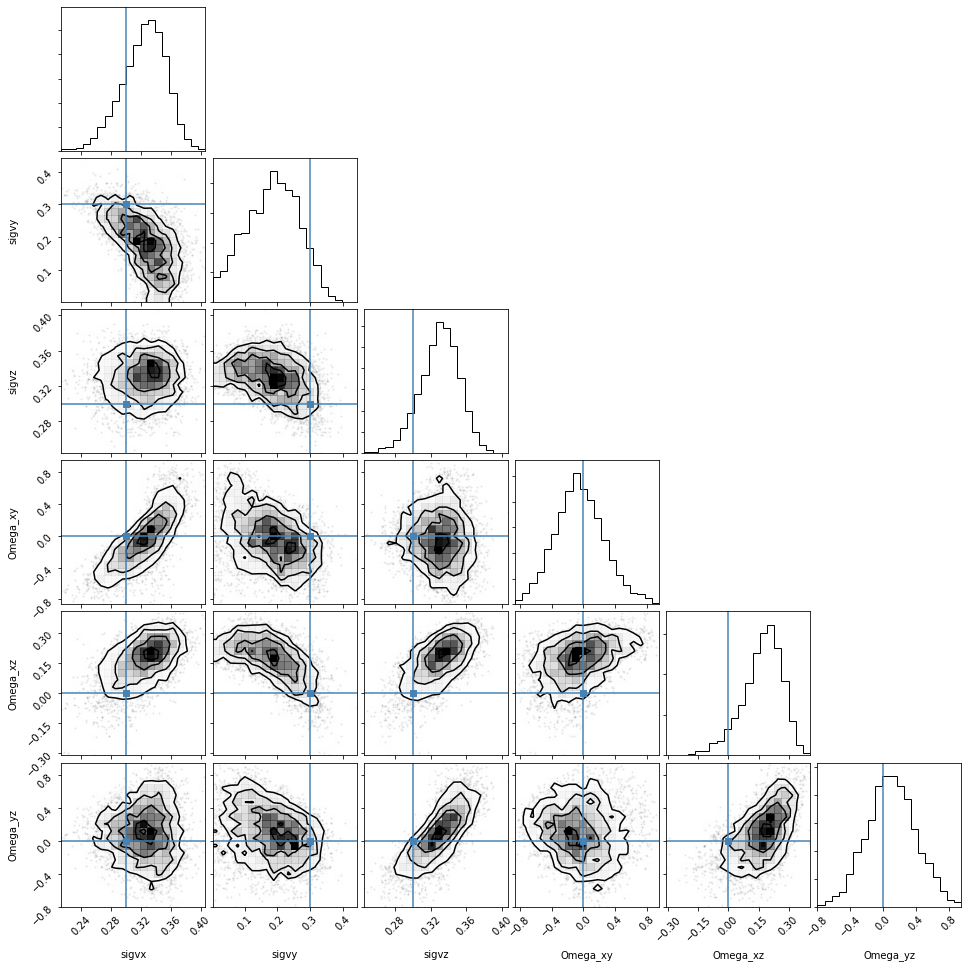

In [40]:
labels = ['sigvx','sigvy','sigvz','Omega_xy','Omega_xz','Omega_yz']
irow,icol = np.triu_indices(3,k=1)
Omega = fit['Omega'][:,irow,icol]
X = np.concatenate((fit['sigv'], Omega), axis=1)
truths = [0.3,0.3,0.3,0,0,0]
corner(X, labels=labels,truths=truths);

## Corner plot - T matrix

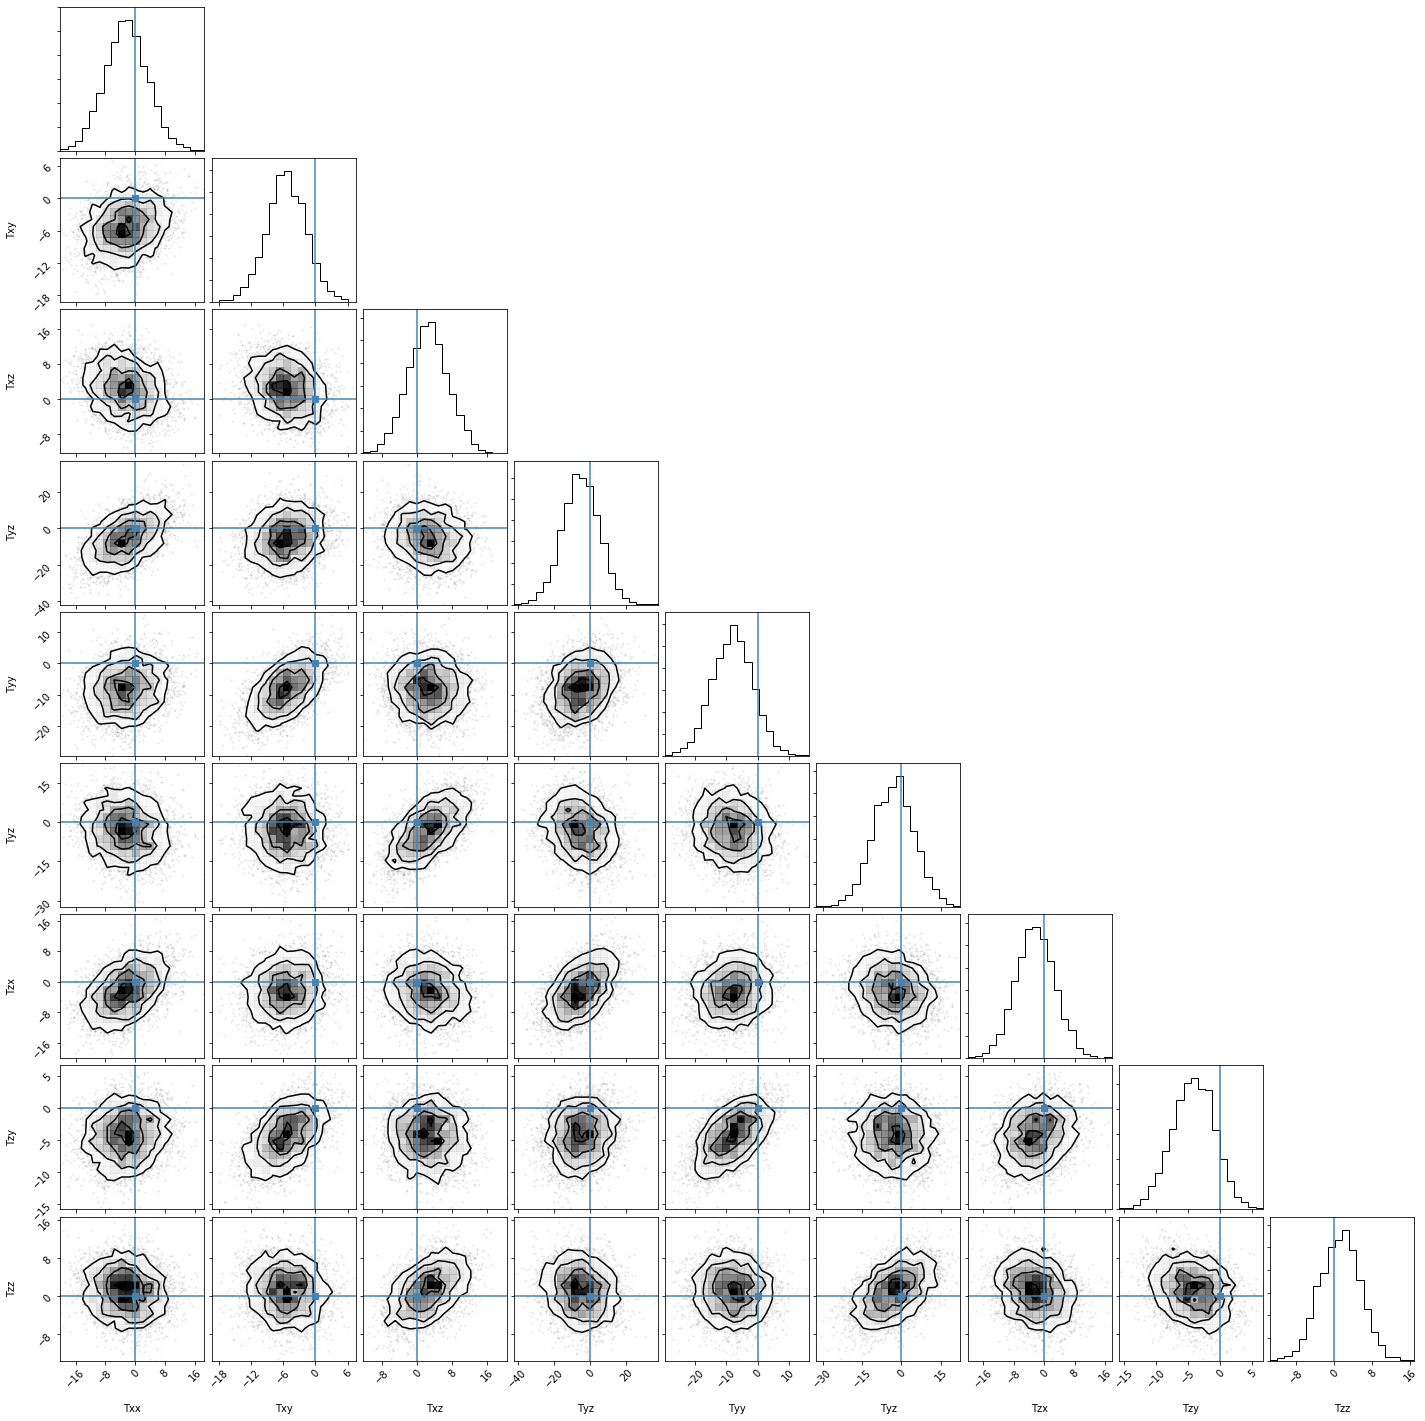

In [26]:
labels = ['Txx','Txy','Txz','Tyz','Tyy','Tyz','Tzx','Tzy','Tzz']
X = fit['T_param'].reshape((4000,-1))
truths = [0]*9
corner(X, labels=labels,truths=truths);

## Corner plot - dispersion scale and background dispersion

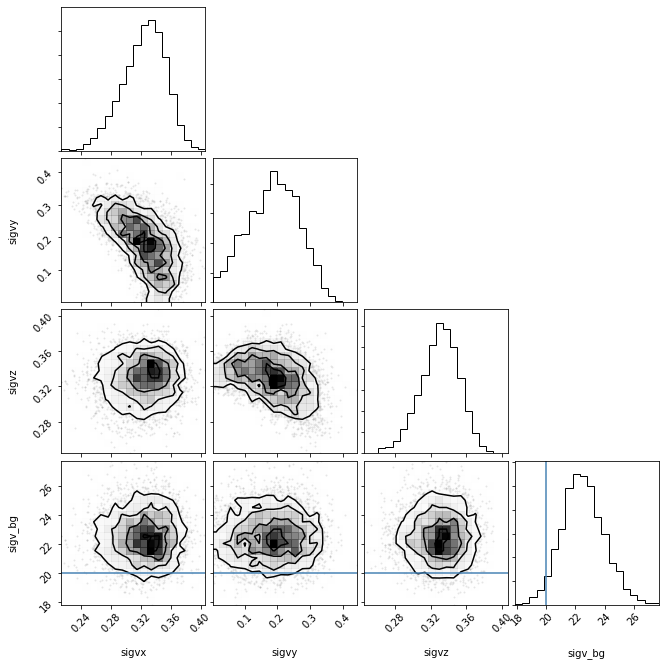

In [53]:
labels = ['sigvx','sigvy','sigvz','sigv_bg']
X = np.concatenate((fit['sigv'],fit['sigv_bg'][:,None]), axis=1)
truths = [-6.32, 45.24, 5.30,20]
corner(X, labels=labels,truths=truths);

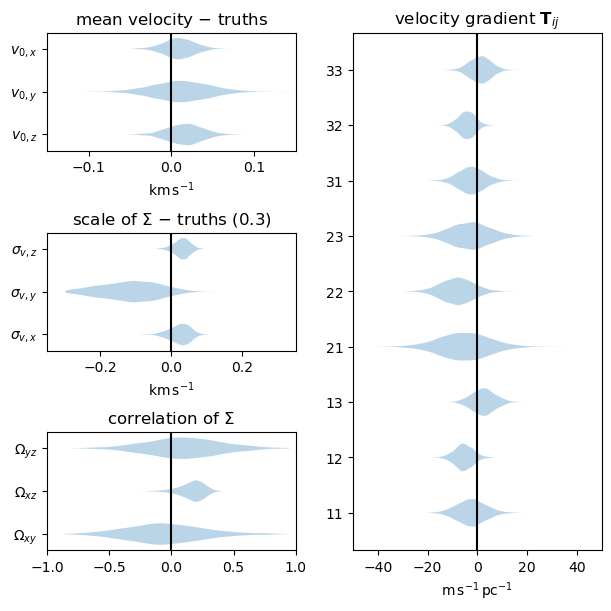

In [51]:
# fit = kn.load_stanfit('../report/hyades-mock-fullmodel/fit.pickle')
fit = kn.load_stanfit('../scripts/mock_null.pickle')

with plt.style.context('default'):
    fig = plt.figure(figsize=(6, 6), constrained_layout=True)
    gs = fig.add_gridspec(3, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[2, 0])
    ax4 = fig.add_subplot(gs[:, 1])

    pars = ['v0','sigv','T_param']
    truths = np.array([0.3, 0.3, 0.3,-6.32, 45.24, 5.30, ])

    dd = (
        fit.to_dataframe(['v0'], diagnostics=False).iloc[:,3:].values
        - np.array([-6.32, 45.24, 5.30])[None])
    ax1.violinplot(
        dd,
        positions=np.r_[1:4:1],
        vert=False, showextrema=False
    )
    ax1.set_yticks([1,2,3])
    ax1.set_yticklabels(['$v_{0,x}$', '$v_{0,y}$', '$v_{0,z}$'][::-1])
    ax1.set_xlabel(r'$\rm km\,\rm s^{-1}$')
    ax1.set_title('mean velocity $-$ truths')
    ax1.set_xlim([-0.15,0.15])

    dd = (
        fit.to_dataframe(['sigv'], diagnostics=False).iloc[:,3:].values
        - np.array([0.3,0.3,0.3])[None])
    ax2.violinplot(
        dd,
        positions=np.r_[1:4:1],
        vert=False, showextrema=False
    )
    ax2.set_yticks([1,2,3])
    ax2.set_yticklabels(['$\sigma_{v,x}$', '$\sigma_{v,y}$', '$\sigma_{v,z}$'])
    ax2.set_xlabel(r'$\rm km\,\rm s^{-1}$')
    ax2.set_title(r'scale of $\Sigma$ $-$ truths (0.3)')
    ax2.set_xlim([-0.35,0.35])

    dd = (
        fit.to_dataframe('Omega', diagnostics=False).iloc[:,[4,5,8]].values
        - np.array([0,0,0])[None])
    ax3.violinplot(
        dd,
        positions=np.r_[1:4:1],
        vert=False, showextrema=False
    )
    ax3.set_yticks([1,2,3])
    ax3.set_yticklabels(['$\Omega_{xy}$', '$\Omega_{xz}$', '$\Omega_{yz}$'])
    ax3.set_title('correlation of $\Sigma$')
    ax3.set_xlim(-1,1)

    dd = (
        fit.to_dataframe('T_param', diagnostics=False).iloc[:,3:].values
        - np.array([0]*9)[None])
    ax4.violinplot(
        dd,
        positions=np.r_[1:10:1],
        vert=False, showextrema=False
    )
    ax4.set_yticks(np.arange(1,10))
    ax4.set_yticklabels(['11','12','13','21','22','23','31','32','33'])
    ax4.set_xlabel(r'$\rm m\,\rm s^{-1}\,\rm pc^{-1}$')
    ax4.set_title('velocity gradient $\mathbf {T}_{ij}$')
    ax4.set_xlim(-50,50)

    for cax in fig.axes:
        cax.axvline(0, c='k')
fig.savefig('mock_hyades_dr2_null.pdf')

In [57]:
df = kn.reconstruct_df_from_stanfit(fit)
print(len(df))

515


Check probmem: ideally the last 515-463=52 stars should be non-members.

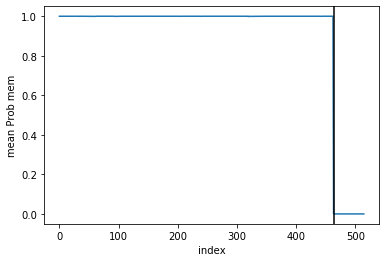

In [65]:
plt.plot(fit['probmem'].mean(axis=0))
plt.xlabel('index')
plt.ylabel('mean Prob mem');
plt.axvline(463,c='k');